# Fashion-Mnist with Pytorch

In this notebook we will learn the basics of training Neural Network models using the Pytorch library.

we will start with validating our Pytourch and Cuda dev (if there are any)

In [1]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())

__Python VERSION: 3.7.5 (default, Dec 20 2019, 12:16:10) 
[Clang 11.0.0 (clang-1100.0.33.16)]
__pyTorch VERSION: 1.4.0
__CUDA VERSION
/bin/sh: nvcc: command not found
__CUDNN VERSION: None
__Number CUDA Devices: 0


pytorch can easily support GPU computation

In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Active CUDA Device: GPU', torch.cuda.current_device())
    print ('Available devices ', torch.cuda.device_count())
    print ('Current cuda device ', torch.cuda.current_device())

In [3]:
print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

USE CUDA=False


Before we start we must set a seed to get same results

In [4]:
import random 
import numpy as np

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

Let's upload the data and visulize it

In [64]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
import seaborn as sns

from torchvision.datasets import FashionMNIST

batch_size = 32

Pytorch have built-in functions for diffrent datasets

we will create a dataloader which will be responsible to fetch the data from the disk to the cpu/gpu


In [65]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

workers = 0
transform = transforms.Compose(
    [transforms.ToTensor(),])
#      transforms.Normalize(0.5, 0.5)])

training_data = FashionMNIST('./datasets/',download=True,train=True,transform=transform)
train_set, val_set = random_split(training_data,[int(training_data.__len__()*0.8),int(training_data.__len__()*0.2)])
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=workers)
val_loader = DataLoader(val_set, batch_size=batch_size,shuffle=True, num_workers=workers)

test_set = FashionMNIST('./datasets/',download=True,train=False,transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=workers)

In [66]:
print('train size=',train_set.__len__(),' validation size=', val_set.__len__())

train size= 48000  validation size= 12000


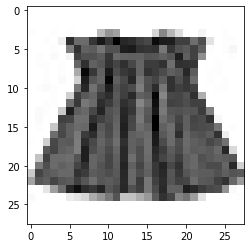

In [67]:
plt.imshow(iter(train_loader).next()[0].numpy()[0][0],cmap='binary')

In [68]:
class_names = {k:v for k,v in enumerate('T-shirt/top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Ankle_boot'.split(' '))}

In [69]:
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle_boot'}

In [70]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.55, -0.35, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, -0.15, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, -0.15, class_names[y[skip+i]], color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()

X_train = iter(train_loader).next()[0].numpy()[:,0,:,:]
y_train = iter(train_loader).next()[1].numpy()

In [71]:
X_train.shape

(32, 28, 28)

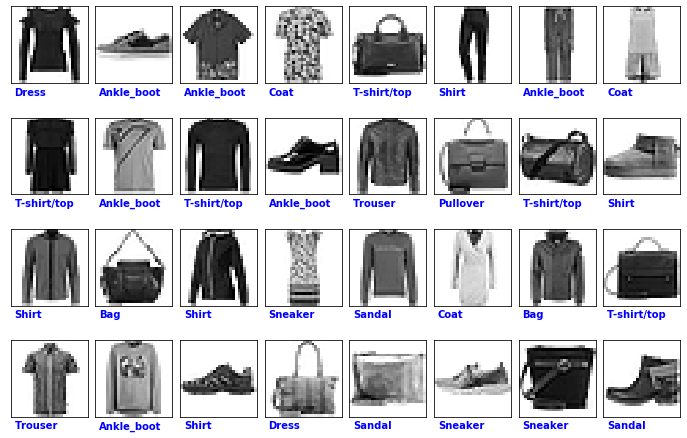

In [72]:
plot_multiple_imgs(X_train,y_train,batch_size//8,8,(12,8))

our initial network will be a fully connected network which means every neuron in a specific layer is connected to every neuron in the succiding layer

In [73]:
import torch.nn as nn
import torch.nn.functional as F

# every network class has to include at least 2 methods:
#     an init method - will define the computational graph components
#     and a forward method which will define the graph structure

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784,64)
        self.fc2 = nn.Linear(64,16)
#         self.fc3 = nn.Linear(128,20)
        self.fc3 = nn.Linear(16,10)
        
    def forward(self,x):
        x = x.view(batch_size,-1)
        x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = F.softmax(self.fc3(x))
        return x
    
m = MLP()

print(m)

MLP(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)


In [80]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(m.parameters(),lr = 0.05, momentum=0.9)

In [81]:
if use_cuda:
    m.cuda()
    criterion.cuda()
        
def get_val_loss(model,val_loader,criterion):
    val_preds = []
    val_true = []
    with torch.no_grad():
        for (inp,labels) in val_loader:
            if use_cuda:
                inp = inp.cuda()
                labels = labels.cuda()
            val_preds.append(model(inp))
            val_true.append(labels)
        val_preds = torch.cat(val_preds)
        val_true = torch.cat(val_true)
    return criterion(val_preds, val_true).item()
  

In [82]:
      
for epoch in range(4):
    running_loss = 0.0
    for i,(inp,labels) in enumerate(train_loader, 0):
        if use_cuda:
            inp = inp.cuda()
            labels = labels.cuda()
        optimizer.zero_grad() # clear the computed gradients from previous passes
        out = m(inp)
        loss = criterion(out, labels)
        loss.backward() # computes gradients for every parameter which has requires_grad=True
        optimizer.step() # update the weights
        running_loss += loss.item()
        if i % (batch_size*10) == (batch_size*10-1):
            print('epoch {}, iteration {}, loss={:3f}, validation_loss={:3f}'.format(epoch,i,running_loss/(batch_size*10),get_val_loss(m,val_loader,criterion)))
            running_loss = 0.0

/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0, iteration 319, loss=1.784466, validation_loss=1.762738
epoch 0, iteration 639, loss=1.781068, validation_loss=1.754766
epoch 0, iteration 959, loss=1.783609, validation_loss=1.761370
epoch 0, iteration 1279, loss=1.761463, validation_loss=1.747353
epoch 1, iteration 319, loss=1.752080, validation_loss=1.758920
epoch 1, iteration 639, loss=1.748541, validation_loss=1.756433
epoch 1, iteration 959, loss=1.757901, validation_loss=1.742990
epoch 1, iteration 1279, loss=1.760131, validation_loss=1.756264
epoch 2, iteration 319, loss=1.746660, validation_loss=1.764909
epoch 2, iteration 639, loss=1.753249, validation_loss=1.745711
epoch 2, iteration 959, loss=1.755041, validation_loss=1.753323
epoch 2, iteration 1279, loss=1.750164, validation_loss=1.741343
epoch 3, iteration 319, loss=1.746889, validation_loss=1.744256
epoch 3, iteration 639, loss=1.747379, validation_loss=1.748206
epoch 3, iteration 959, loss=1.746275, validation_loss=1.786312
epoch 3, iteration 1279, loss=1.75662

In [90]:
class CONV(nn.Module):
    def __init__(self):
        super(CONV, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1,32,3)  #input dims are 1x28x28  output dims are 32x26x26
        self.conv2 = nn.Conv2d(32,32,3)  #input dims are 32x26x26  output dims are 32x24x24
        self.conv3 = nn.Conv2d(32,16,3)  #input dims are 32x12x12  output dims are 16x10x10
        self.conv4 = nn.Conv2d(16,16,3)  #input dims are 16x10x10  output dims are 16x8x8
        self.flat_dim = (4*4)*16
        self.fc1 = nn.Linear(self.flat_dim,20) 
        self.fc2 = nn.Linear(20,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1,self.flat_dim)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [91]:
c = CONV()
print(c)

CONV(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)


In [92]:
optimizer = optim.Adam(c.parameters(),lr = 0.001)

In [93]:
if use_cuda:
    c.cuda()
    criterion.cuda()
        
for epoch in range(4):
    running_loss = 0.0
    for i,(inp,labels) in enumerate(train_loader, 0):
        if use_cuda:
            inp = inp.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        out = c(inp)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % (batch_size*10) == (batch_size*10-1):
            print('epoch {}, iteration {}, loss={:3f}'.format(epoch,i,running_loss/(batch_size*10)))
            running_loss = 0.0

/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0, iteration 319, loss=1.950569
epoch 0, iteration 639, loss=1.790805
epoch 0, iteration 959, loss=1.773438
epoch 0, iteration 1279, loss=1.751599
epoch 1, iteration 319, loss=1.731536
epoch 1, iteration 639, loss=1.737114
epoch 1, iteration 959, loss=1.731422
epoch 1, iteration 1279, loss=1.721267
epoch 2, iteration 319, loss=1.711441
epoch 2, iteration 639, loss=1.713312
epoch 2, iteration 959, loss=1.713189
epoch 2, iteration 1279, loss=1.709194
epoch 3, iteration 319, loss=1.699420
epoch 3, iteration 639, loss=1.696543
epoch 3, iteration 959, loss=1.697174
epoch 3, iteration 1279, loss=1.693864
